In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [223]:
# file paths
path_pid_rounded_imu = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/PID_tests_neu/2025-03-11_15-10-26.sensors.dat"
path_pid_rounded_cam = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/PID_tests_neu/2025-03-11_15-10-26.dat"

path_motors_none_rounded_imu = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/Motors_None_Rounded/2025-01-22_17-03-38.sensors.dat"
path_motors_none_rounded_cam = "c:/Users/charl/Desktop/Uni_Leipzig/MA/Code/PlatformIO/IMU_Audit/MA_files/Recherche/Ergebnisse/Motors_None_Rounded/2025-01-22_17-03-38.dat"

In [224]:
# Motorbasierte Fahrweise

column_names_motors = ["frame", "start_stopp", "empty0", "empty1", "empty2", "empty3", "empty4"]

df_path_motors_none_rounded_imu = pd.read_csv(path_motors_none_rounded_imu, sep=' ', header=None, names=column_names_motors)
df_path_motors_none_rounded_cam = pd.read_csv(path_motors_none_rounded_cam, sep=' ', header=0)

df_imu_motors = df_path_motors_none_rounded_imu
df_imu_motors['start_stopp'] = df_imu_motors['start_stopp'].apply(lambda x: 1 if x == 0 else 0) 
df_cam_motors = df_path_motors_none_rounded_cam


# PID

column_names_pid = ["frame", "event"]

df_path_imu_pid_rounded_imu = pd.read_csv(path_pid_rounded_imu, sep=' ', header=0)
df_path_imu_pid_rounded_imu.rename(columns={"event": "start_stopp"}, inplace=True)
df_path_imu_pid_rounded_cam = pd.read_csv(path_pid_rounded_cam, sep=' ', header=0)

df_imu_pid = df_path_imu_pid_rounded_imu
df_cam_pid = df_path_imu_pid_rounded_cam
# df_imu_pid filtern nach nicht start_stopp == 2
df_imu_pid = df_imu_pid[df_imu_pid['start_stopp'] != 2]


# df_imu_motors.head()
# df_imu_pid.head()


In [225]:
def cyclic_mean(series, period=2 * np.pi):
    # Umwandlung der Werte in Radien (wenn nicht bereits im passenden Bereich)
    radians = series * (2 * np.pi / period)  # Normierung auf [0, 2π]
    
    # Umrechnung in kartesische Koordinaten
    x = np.cos(radians)
    y = np.sin(radians)
    
    # Durchschnitt der kartesischen Koordinaten berechnen
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Zurück in zyklischen Winkel umrechnen
    mean_angle = np.arctan2(mean_y, mean_x)
    
    # Ergebnis auf den ursprünglichen Zyklus zurückskalieren
    cyclic_mean_value = (mean_angle % (2 * np.pi)) * (period / (2 * np.pi))
    
    return cyclic_mean_value

def cyclic_difference(value1, value2, period=2 * np.pi):
    raw_diff = value1 - value2
    cyclic_diff = (raw_diff + period / 2) % period - period / 2
    return cyclic_diff

In [226]:
results_pid = []

# Iteration über jede Zeile von df_imu
for _, row in df_imu_pid.iterrows():
    frame_value = row['frame']
    start_stopp = row['start_stopp']
    
    # Finde die Zeile in df_cam, die diesem frame entspricht
    df_cam_before_frame = df_cam_pid[df_cam_pid['frame'] < frame_value]
    
    # Berechne den Durchschnitt der letzten 20 Werte in der 'angle'-Spalte
    if len(df_cam_before_frame) >= 20:
        last_20_values = df_cam_before_frame['phi'].tail(20)
        avg_angle_last_20 = cyclic_mean(last_20_values, period=2 * np.pi)
    else:
        # Falls weniger als 20 Werte vorhanden sind, den Durchschnitt der verfügbaren berechnen
        avg_angle_last_20 = cyclic_mean(df_cam_before_frame['phi'], period=2 * np.pi)
    
    # Finde die Zeile in df_cam, die dem nächsten frame entspricht
    df_cam_after_frame = df_cam_pid[df_cam_pid['frame'] > frame_value]

    # Berechne den Durchschnitt der nächsten 20 Werte in der 'angle'-Spalte
    if len(df_cam_after_frame) >= 20:
        next_20_values = df_cam_after_frame['phi'].head(20)
        avg_angle_next_20 = cyclic_mean(next_20_values, period=2 * np.pi)
    else:
        # Falls weniger als 20 Werte vorhanden sind, den Durchschnitt der verfügbaren berechnen
        avg_angle_next_20 = cyclic_mean(df_cam_after_frame['phi'], period=2 * np.pi)
    
    # Füge das Ergebnis in das neue DataFrame hinzu
    results_pid.append({'frame': frame_value, 'start_stopp': start_stopp, 'avg_angle_last_20': avg_angle_last_20, 'avg_angle_next_20': avg_angle_next_20})

# Konvertiere die Ergebnisse in ein DataFrame
result_df_pid = pd.DataFrame(results_pid)

# für pid tests: result_df abschneiden nach 109 werten
# result_df_pid = result_df_pid.head(109)
result_df_pid



,frame,start_stopp,avg_angle_last_20,avg_angle_next_20
0,454,0,1.570800,1.594229
1,544,1,2.677093,3.073156
2,724,0,3.117817,3.129634
3,813,1,4.221560,4.576845
4,993,0,4.581672,4.574808
...,...,...,...,...
72,10166,0,5.625757,5.623095
73,10257,1,0.424100,0.800656
74,10437,0,0.823673,0.861033
75,10526,1,1.932835,2.307553


In [227]:
results_motors = []

# Iteration über jede Zeile von df_imu
for _, row in df_imu_motors.iterrows():
    frame_value = row['frame']
    start_stopp = row['start_stopp']
    
    # Finde die Zeile in df_cam, die diesem frame entspricht
    df_cam_before_frame = df_cam_motors[df_cam_motors['frame'] < frame_value]
    
    # Berechne den Durchschnitt der letzten 20 Werte in der 'angle'-Spalte
    if len(df_cam_before_frame) >= 20:
        last_20_values = df_cam_before_frame['phi'].tail(20)
        avg_angle_last_20 = cyclic_mean(last_20_values, period=2 * np.pi)
    else:
        # Falls weniger als 20 Werte vorhanden sind, den Durchschnitt der verfügbaren berechnen
        avg_angle_last_20 = cyclic_mean(df_cam_before_frame['phi'], period=2 * np.pi)
    
    # Finde die Zeile in df_cam, die dem nächsten frame entspricht
    df_cam_after_frame = df_cam_motors[df_cam_motors['frame'] > frame_value]

    # Berechne den Durchschnitt der nächsten 20 Werte in der 'angle'-Spalte
    if len(df_cam_after_frame) >= 20:
        next_20_values = df_cam_after_frame['phi'].head(20)
        avg_angle_next_20 = cyclic_mean(next_20_values, period=2 * np.pi)
    else:
        # Falls weniger als 20 Werte vorhanden sind, den Durchschnitt der verfügbaren berechnen
        avg_angle_next_20 = cyclic_mean(df_cam_after_frame['phi'], period=2 * np.pi)
    
    # Füge das Ergebnis in das neue DataFrame hinzu
    results_motors.append({'frame': frame_value, 'start_stopp': start_stopp, 'avg_angle_last_20': avg_angle_last_20, 'avg_angle_next_20': avg_angle_next_20})

# Konvertiere die Ergebnisse in ein DataFrame
result_df_motors = pd.DataFrame(results_motors)

# für Motors-Tests: result_df abschneiden nach 109 Werten
# result_df_motors = result_df_motors.head(109)
result_df_motors


,frame,start_stopp,avg_angle_last_20,avg_angle_next_20
0,733,0,1.559141,1.623038
1,812,1,2.701154,3.019091
2,937,0,3.064037,3.165706
3,1015,1,4.228070,4.510374
4,1140,0,4.537270,4.653537
...,...,...,...,...
88,9684,0,5.239521,5.333934
89,9763,1,0.135199,0.441453
90,9888,0,0.391546,0.520549
91,9966,1,1.595107,1.921781


In [235]:
###### STRECKEN FINDEN ######

# Initialisieren der Variablen
segments = []
segment_number = 1

# Schleife über result_df_pid: wenn aktuelle Zeile start_stopp = 1 und nächste Zeile start_stopp = 0, dann Segment hinzufügen
for i in range(len(result_df_pid) - 1):
    if result_df_pid.iloc[i]['start_stopp'] == 1 and result_df_pid.iloc[i + 1]['start_stopp'] == 0:

        before_angle = result_df_pid.iloc[i]['avg_angle_last_20']
        after_angle = result_df_pid.iloc[i + 1]['avg_angle_next_20']

        angle_diff = cyclic_difference(after_angle, before_angle)

        start_frame = result_df_pid.iloc[i]['frame']
        end_frame = result_df_pid.iloc[i + 1]['frame']

        frame_diff = result_df_pid.iloc[i + 1]['frame'] - result_df_pid.iloc[i]['frame']

        segments.append({
            'segment_number': segment_number, 
            'start_frame': start_frame, 
            'end_frame': end_frame,
            'frame_diff': frame_diff,
            'before_angle': before_angle,
            'after_angle': after_angle,
            'angle_diff': angle_diff,
        })
        segment_number += 1

# Konvertiere die Liste der Segmente in ein DataFrame
segments_df_pid = pd.DataFrame(segments)

segments_df_pid = segments_df_pid[segments_df_pid['segment_number'] <= 36]

segments_df_pid.tail()


,segment_number,start_frame,end_frame,frame_diff,before_angle,after_angle,angle_diff
31,32,8908.0,9087.0,179.0,5.444074,5.856504,0.412429
32,33,9177.0,9358.0,181.0,0.660608,1.081744,0.421136
33,34,9447.0,9628.0,181.0,2.197342,2.624368,0.427026
34,35,9718.0,9898.0,180.0,3.677912,4.106595,0.428683
35,36,9988.0,10166.0,178.0,5.233420,5.623095,0.389675


In [236]:
###### STRECKEN FINDEN ######

# Initialisieren der Variablen
segments_motors = []
segment_number = 1

# Schleife über result_df_motors: wenn aktuelle Zeile start_stopp = 1 und nächste Zeile start_stopp = 0, dann Segment hinzufügen
for i in range(len(result_df_motors) - 1):
    if result_df_motors.iloc[i]['start_stopp'] == 1 and result_df_motors.iloc[i + 1]['start_stopp'] == 0:

        before_angle = result_df_motors.iloc[i]['avg_angle_last_20']
        after_angle = result_df_motors.iloc[i + 1]['avg_angle_next_20']

        angle_diff = cyclic_difference(after_angle, before_angle)

        start_frame = result_df_motors.iloc[i]['frame']
        end_frame = result_df_motors.iloc[i + 1]['frame']

        frame_diff = result_df_motors.iloc[i + 1]['frame'] - result_df_motors.iloc[i]['frame']

        segments_motors.append({
            'segment_number': segment_number, 
            'start_frame': start_frame, 
            'end_frame': end_frame,
            'frame_diff': frame_diff,
            'before_angle': before_angle,
            'after_angle': after_angle,
            'angle_diff': angle_diff,
        })
        segment_number += 1

# Konvertiere die Liste der Segmente in ein DataFrame
segments_df_motors = pd.DataFrame(segments_motors)

segments_df_motors = segments_df_motors[segments_df_motors['segment_number'] <= 36]

segments_df_motors.tail()



,segment_number,start_frame,end_frame,frame_diff,before_angle,after_angle,angle_diff
31,32,7118.0,7243.0,125.0,0.151732,0.506117,0.354384
32,33,7321.0,7446.0,125.0,1.580546,2.023876,0.443329
33,34,7525.0,7650.0,125.0,3.103857,3.508306,0.404449
34,35,7728.0,7853.0,125.0,4.593101,4.928251,0.335151
35,36,7931.0,8057.0,126.0,5.982405,0.017185,0.317965


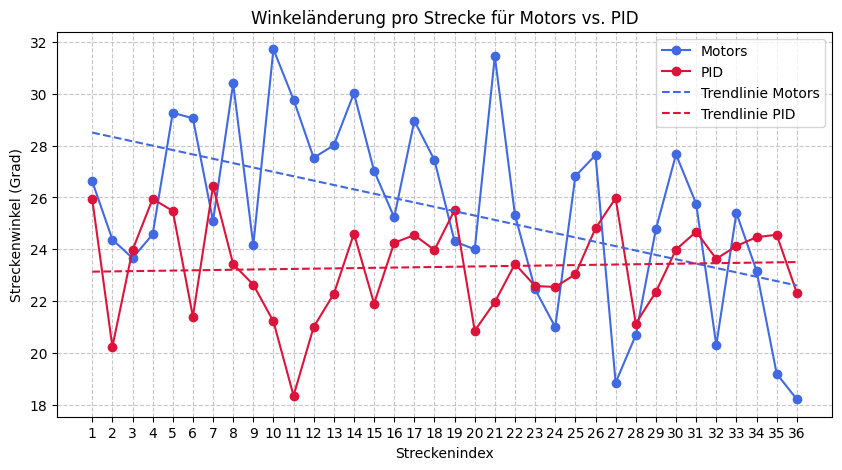

In [242]:
import matplotlib.pyplot as plt

# Erstellen der Abbildung
plt.figure(figsize=(10, 5))

# Umrechnung von Radian in Grad
segments_df_motors['angle_diff_deg'] = segments_df_motors['angle_diff'] * (180 / np.pi)
segments_df_pid['angle_diff_deg'] = segments_df_pid['angle_diff'] * (180 / np.pi)

# Plot für segments_df_motors
plt.plot(segments_df_motors['segment_number'], segments_df_motors['angle_diff_deg'], 
         marker='o', linestyle='-', color='royalblue', label='Motors')

# Plot für segments_df_pid
plt.plot(segments_df_pid['segment_number'], segments_df_pid['angle_diff_deg'], 
         marker='o', linestyle='-', color='crimson', label='PID')

# Lineare Regression für segments_df_motors
motor_coeffs = np.polyfit(segments_df_motors['segment_number'], segments_df_motors['angle_diff_deg'], 1)
motor_trendline = np.poly1d(motor_coeffs)
plt.plot(segments_df_motors['segment_number'], motor_trendline(segments_df_motors['segment_number']), 
         color='royalblue', linestyle='--', label='Trendlinie Motors')

# Lineare Regression für segments_df_pid
pid_coeffs = np.polyfit(segments_df_pid['segment_number'], segments_df_pid['angle_diff_deg'], 1)
pid_trendline = np.poly1d(pid_coeffs)
plt.plot(segments_df_pid['segment_number'], pid_trendline(segments_df_pid['segment_number']), 
         color='crimson', linestyle='--', label='Trendlinie PID')

# Achsentitel setzen
plt.xlabel("Streckenindex")
plt.ylabel("Streckenwinkel (Grad)")

# Titel hinzufügen
plt.title("Winkeländerung pro Strecke für Motors vs. PID")

# Achsenbeschriftungen verbessern
plt.xticks(segments_df_motors['segment_number'])

# Gitter hinzufügen
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend()

# Diagramm anzeigen
plt.show()


In [232]:
# durchschnitt für angle_diff aus segments_df berechnen
angle_diff_avg = segments_df['angle_diff'].mean()
angle_diff_std = segments_df['angle_diff'].std()
angle_diff_min = segments_df['angle_diff'].min()
angle_diff_max = segments_df['angle_diff'].max()
print("angle_diff_avg:", angle_diff_avg)
print("angle_diff_std:", angle_diff_std)
print("angle_diff_min:", angle_diff_min)
print("angle_diff_max:", angle_diff_max)

print((np.pi)/2)

angle_diff_avg: 0.40755667577494387
angle_diff_std: 0.03263619284962804
angle_diff_min: 0.32034845385470057
angle_diff_max: 0.46151009834284995
1.5707963267948966


In [233]:
angle_diff_avg_motors = 0.4460001618115092
angle_diff_std_motors = 0.061725740441976824
angle_diff_min_motors = 0.31796479702603
angle_diff_max_motors = 0.5535700740401435

angle_diff_avg_pid = 0.40755667577494387
angle_diff_std_pid = 0.03263619284962804
angle_diff_min_pid = 0.32034845385470057
angle_diff_max_pid = 0.46151009834284995

pid_strecke = [angle_diff_avg_pid, angle_diff_min_pid, angle_diff_max_pid]
motors_strecke = [angle_diff_avg_motors, angle_diff_min_motors, angle_diff_max_motors]


C:\Users\charl\AppData\Local\Temp\ipykernel_20324\3969738482.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


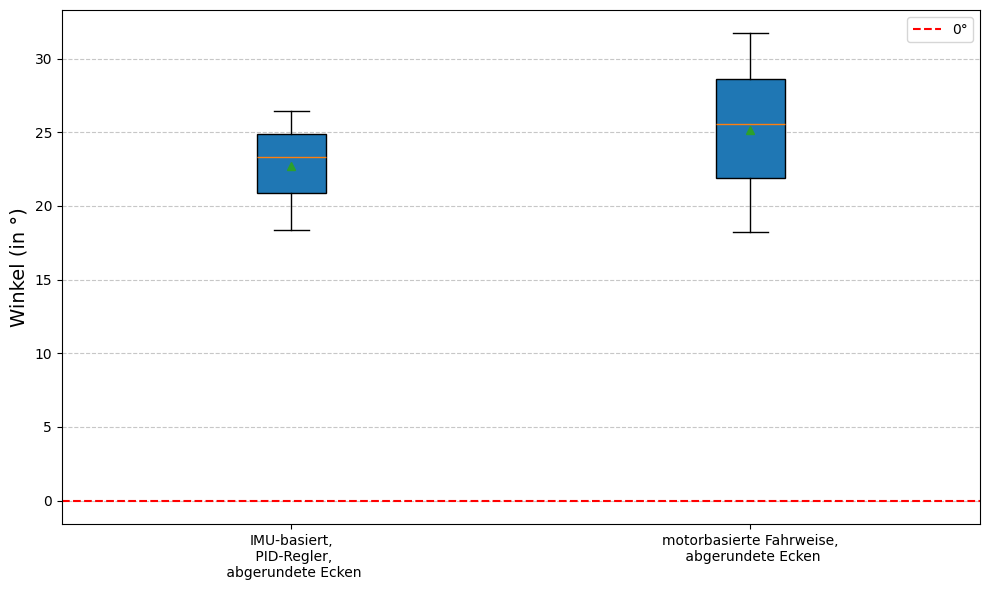

In [234]:
# Daten in Radian
data = {
    "IMU-basiert,\n PID-Regler,\n abgerundete Ecken": pid_strecke,
    "motorbasierte Fahrweise,\n abgerundete Ecken": motors_strecke
}

# Daten von Radian in Grad umrechnen
data_deg = {key: [np.degrees(value) for value in values] for key, values in data.items()}

# Boxplot erstellen
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(
    data_deg.values(), 
    vert=True, 
    patch_artist=True, 
    labels=data_deg.keys(), 
    showmeans=True
)

# Stil und Beschriftung
# ax.set_title("Boxplot für gefahrene Winkel (in °)", fontsize=16)
ax.set_ylabel("Winkel (in °)", fontsize=14)
ax.axhline(y=np.degrees(0), color='r', linestyle='--', label=r"0°")
ax.legend()

# Plot anzeigen
plt.xticks()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
